In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from experience import load_experience
from bclassification.utils_base import (
    print_class_weights,
    compute_weight_bias,
    print_dataset,
    plot_metrics,
    plot_roc,
    describe_results,
)
from bclassification.utils_fcn import create_dataset
from bclassification.dnn import load_dnn
from lib.constants import Constants as Const
from lib.data_utils import (
    make_dir,
    env_pf,
    create_results_dir,
    save_dict_to_file,
)
from lib.tf_utils import (
    print_variables,
    MatthewsCorrelationCoefficient,
)
from lib.visualizer import pprint


experience_dir = make_dir(os.path.join(Const.EXPERIENCE_DIR, "data-aug"))
results_dir = make_dir(os.path.join(Const.RESULTS_DIR, "paper"))

agent_name = "agent-mip"
case_name = "l2rpn_2019_art"
env_dc = True
verbose = False

case_results_dir = make_dir(os.path.join(results_dir, f"{case_name}-{env_pf(env_dc)}"))
case, collector = load_experience(case_name, agent_name, experience_dir, env_dc=env_dc)


L2RPN_2019_ART (dc)


--------------------------------------------------------------------------------
                                        Loading Experience
--------------------------------------------------------------------------------
    - Loading chronics:                 ./experience/data-aug/l2rpn_2019_art-dc/agent-mip-chronic-****
    - Number of loaded chronics:        122


In [2]:
"""
    Parameters
"""

random_seed = 0

input_mode = "structured"
label_mode = "dn"

n_window_targets = 12  # 0 or 12
n_window_history = 0
downsampling_rate = 0.10
n_window_forecasts = 1
use_actions = True
feature_scaling = True
batch_normalization = False

val_frac = 0.10
test_frac = 0.10

# Model
model_type = "res"  # "fc" or "res"
dropout_rate = 0
l1_reg = 1e-7
l2_reg = 0
n_hidden = 512
n_hidden_layers = 4
threshold = 0.50
pos_scaling = 1

# Training
learning_rate = 1e-5
n_batch = 512
n_epochs = 200

In [3]:
"""
    Dataset
"""

_, _, mask_targets, X_all, Y_all, p_scaling_std = create_dataset(
    case,
    collector,
    input_mode=input_mode,
    label_mode=label_mode,
    n_window_history=n_window_history,
    n_window_targets=n_window_targets,
    downsampling_rate=downsampling_rate,
    n_window_forecasts=n_window_forecasts,
    use_actions=use_actions,
    feature_scaling=feature_scaling,
)

    - Input structure:                  structured
    - Label structure:                  dn
    - Labels:                           7626/740873	1.03 %


In [4]:
"""
    Dataset Split
"""

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

chronics_train, chronics_val = train_test_split(
     collector.chronic_ids, test_size=val_frac, random_state=random_seed
)

chronics_train, chronics_test = train_test_split(
     chronics_train, test_size=test_frac / (1 - val_frac), random_state=random_seed
)

chronics_train.sort()
chronics_val.sort()
chronics_test.sort()

pprint("train:", chronics_train)
pprint("val:", chronics_val)
pprint("test:", chronics_test)

train_ids = np.zeros_like(Y_all, dtype=np.bool)
val_ids = np.zeros_like(Y_all, dtype=np.bool)
test_ids = np.zeros_like(Y_all, dtype=np.bool)

start = 0
for chronic_id, chronic_len in zip(collector.chronic_ids, collector.chronic_lengths):
    end = start + chronic_len
    
    if chronic_id in chronics_train:
        train_ids[start:end] = True
    elif chronic_id in chronics_val:
        val_ids[start:end] = True
    elif chronic_id in chronics_test:
        test_ids[start:end] = True
    start = end

# test
pprint("intersection", np.sum(train_ids &  val_ids &  test_ids))
pprint("union", np.sum(train_ids |  val_ids |  test_ids))

mask_train = mask_targets & train_ids
mask_val = mask_targets & val_ids
mask_test = mask_targets & test_ids

X_train, Y_train = X_all[mask_train, :], Y_all[mask_train]
X_val, Y_val = X_all[mask_val, :], Y_all[mask_val]
X_test, Y_test = X_all[mask_test, :], Y_all[mask_test]

train:                                  [0, 1, 2, 5, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 85, 87, 88, 89, 91, 92, 93, 94, 96, 98, 99, 100, 101, 102, 103, 120, 121, 122, 124, 126, 127, 128, 151, 152, 153, 154, 155, 156, 157, 159]
val:                                    [7, 8, 10, 22, 33, 45, 61, 71, 84, 86, 90, 97, 125]
test:                                   [3, 4, 6, 14, 16, 26, 37, 44, 78, 83, 95, 123, 158]
intersection                            0
union                                   740873


In [5]:
%%capture cap --no-stderr
class_weight, initial_bias = compute_weight_bias(Y_all[mask_targets])
initial_bias = 0
class_weight[1] = class_weight[1] * pos_scaling 

print_dataset(X_all, Y_all, "All data")
print_dataset(X_all[mask_targets], Y_all[mask_targets], "Data")
print_dataset(X_train, Y_train, "Train")
print_dataset(X_val, Y_val, "Validation")
print_dataset(X_test, Y_test, "Test")

print_class_weights(class_weight)
pprint("Initial bias:", "{:.4f}".format(float(initial_bias)))

model_dir = create_results_dir(case_results_dir, model_name=model_type)

In [6]:
"""
    Model
"""

metrics = [
    tf.keras.metrics.TruePositives(thresholds=threshold, name="tp"),
    tf.keras.metrics.FalsePositives(thresholds=threshold, name="fp"),
    tf.keras.metrics.TrueNegatives(thresholds=threshold, name="tn"),
    tf.keras.metrics.FalseNegatives(thresholds=threshold, name="fn"),
    tf.keras.metrics.BinaryAccuracy(threshold=threshold, name="accuracy"),
    tf.keras.metrics.Precision(thresholds=threshold, name="precision"),
    tf.keras.metrics.Recall(thresholds=threshold, name="recall"),
    MatthewsCorrelationCoefficient(threshold=threshold, name="mcc"),
    tf.keras.metrics.AUC(name="auc"),
]

input_dim = X_train.shape[-1]

tf.random.set_seed(random_seed)


model = load_dnn(
    input_dim,
    n_hidden_layers,
    n_hidden,
    model_type,
    l1_reg,
    l2_reg,
    dropout_rate,
    batch_normalization,
    initial_bias,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

checkpoint_path = os.path.join(model_dir, "ckpts")
ckpt = tf.train.Checkpoint(model=model, optimizer=model.optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

pprint("Model directory:", model_dir)
    
param_dict = {
        "random_seed": random_seed,
        "input_mode": input_mode,
        "label_mode": label_mode,
        "val_frac": val_frac,
        "downsampling_rate": downsampling_rate,
        "n_window_targets": n_window_targets,
        "n_window_history": n_window_history,
        "n_window_forecasts": n_window_forecasts,
        "use_actions": use_actions,
        "feature_scaling": feature_scaling,
        "p_scaling_std": p_scaling_std,
        "model_type": model_type,
        "input_dim": input_dim,
        "dropout_rate": dropout_rate,
        "l1_reg": l1_reg,
        "l2_reg": l2_reg,
        "n_hidden": n_hidden,
        "n_hidden_layers": n_hidden_layers,
        "learning_rate": learning_rate,
        "n_batch": n_batch,
        "n_epochs": n_epochs,
        "threshold": threshold,
        "pos_scaling": pos_scaling,
        "batch_normalization": batch_normalization,
}
print(json.dumps(param_dict, indent=2, sort_keys=True))
save_dict_to_file(
    param_dict,
    os.path.join(model_dir, "params.txt"),
)

Model directory:                        ./results\paper\l2rpn_2019_art-dc\2021-04-06_12-31-09_res
{
  "batch_normalization": false,
  "downsampling_rate": 0.1,
  "dropout_rate": 0,
  "feature_scaling": true,
  "input_dim": 214,
  "input_mode": "structured",
  "l1_reg": 1e-07,
  "l2_reg": 0,
  "label_mode": "dn",
  "learning_rate": 1e-05,
  "model_type": "res",
  "n_batch": 512,
  "n_epochs": 200,
  "n_hidden": 512,
  "n_hidden_layers": 4,
  "n_window_forecasts": 1,
  "n_window_history": 0,
  "n_window_targets": 12,
  "p_scaling_std": 58.85773291362035,
  "pos_scaling": 1,
  "random_seed": 0,
  "threshold": 0.5,
  "use_actions": true,
  "val_frac": 0.1
}


In [7]:
"""
    Training
"""

training = model.fit(
    X_train,
    Y_train,
    epochs=n_epochs,
    batch_size=n_batch,
    class_weight=class_weight,
    validation_data=(X_val, Y_val),
    verbose=3,
)

ckpt_save_path = ckpt_manager.save()
pprint(f"    - Saving checkpoint to:", ckpt_save_path)

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

In [8]:
%%capture cap --no-stderr
"""
    Results
"""
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
from lib.rewards import correct_predictions

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    pprint("Restoring checkpoint from:", ckpt_manager.latest_checkpoint)

print_variables(model.trainable_variables)
plot_metrics(training, Y_train, Y_val, save_dir=model_dir)

results_train = model.evaluate(X_train, Y_train, batch_size=n_batch, verbose=0)
results_val = model.evaluate(X_val, Y_val, batch_size=n_batch, verbose=0)
results_test = model.evaluate(X_test, Y_test, batch_size=n_batch, verbose=0)

Y_train_pred = model.predict(X_train, batch_size=n_batch)
Y_val_pred = model.predict(X_val, batch_size=n_batch)
Y_test_pred = model.predict(X_test, batch_size=n_batch)

describe_results(model.metrics_names, results_train, Y_train, name="Train")
pprint("    - F1:", "{:.4f}".format(f1_score(Y_train, np.greater(Y_train_pred, threshold)), average="binary"))
describe_results(model.metrics_names, results_val, Y_val, name="Validation")
pprint("    - F1:", "{:.4f}".format(f1_score(Y_val, np.greater(Y_val_pred, threshold)), average="binary"))
describe_results(model.metrics_names, results_test, Y_test, name="Test")
pprint("    - F1:", "{:.4f}".format(f1_score(Y_test, np.greater(Y_test_pred, threshold)), average="binary"))

plot_roc(
    [
        ("Training", Y_train, Y_train_pred),
        ("Validation", Y_val, Y_val_pred),
        ("Test", Y_test, Y_test_pred),
    ],
    save_dir=model_dir,
)

Y_all_train_pred = np.greater(model.predict(X_all[train_ids, :], batch_size=n_batch), threshold) 
Y_all_val_pred = np.greater(model.predict(X_all[val_ids, :], batch_size=n_batch), threshold)
Y_all_test_pred = np.greater(model.predict(X_all[test_ids, :], batch_size=n_batch), threshold)

Restoring checkpoint from:              ./results\paper\l2rpn_2019_art-dc\2021-04-06_12-31-09_res\ckpts\ckpt-1
Name                                         Shape	   Param #	   L2-Norm
dense_4/kernel:0                        (214, 512)	    109568	     11.58
dense_4/bias:0                              (512,)	       512	      0.05
residula_fc_block/dense/kernel:0        (512, 512)	    262144	     18.69
residula_fc_block/dense/bias:0              (512,)	       512	      0.02
residula_fc_block/dense_1/kernel:0      (512, 512)	    262144	     20.51
residula_fc_block/dense_1/bias:0            (512,)	       512	      0.03
residula_fc_block_1/dense_2/kernel:0    (512, 512)	    262144	     20.16
residula_fc_block_1/dense_2/bias:0          (512,)	       512	      0.02
residula_fc_block_1/dense_3/kernel:0    (512, 512)	    262144	     20.61
residula_fc_block_1/dense_3/bias:0          (512,)	       512	      0.04
dense_5/kernel:0                          (512, 1)	       512	      1.84
dense_5/bias:

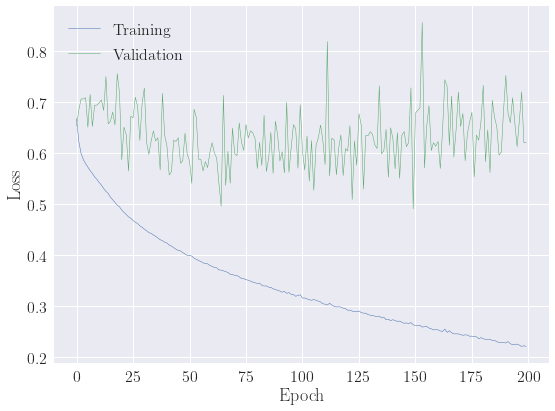

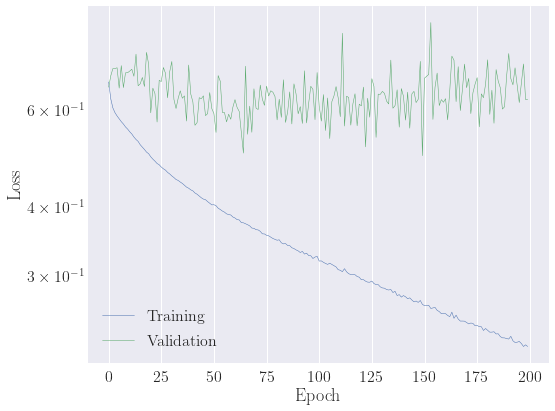

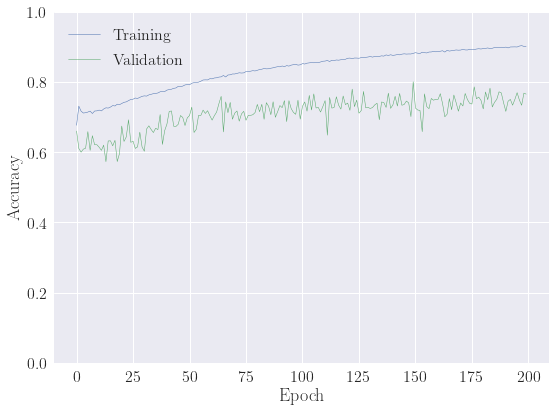

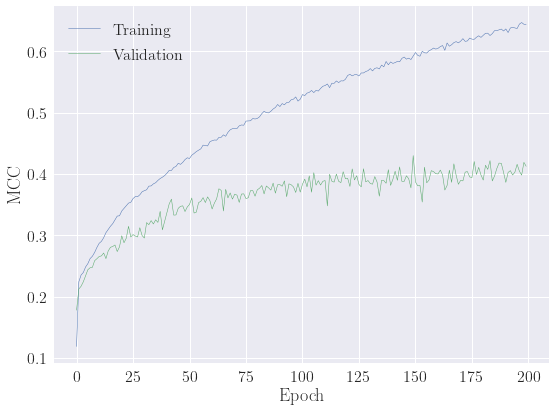

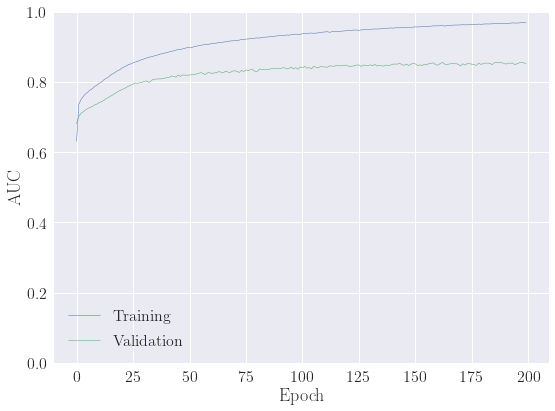

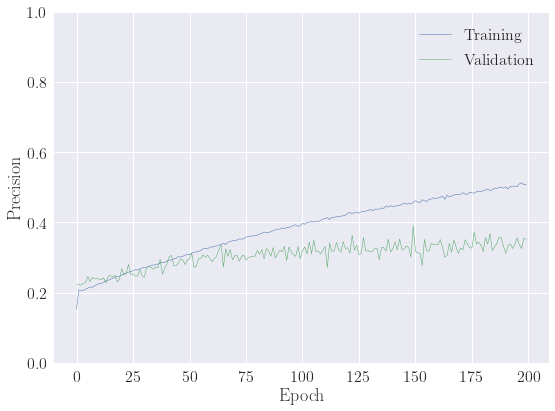

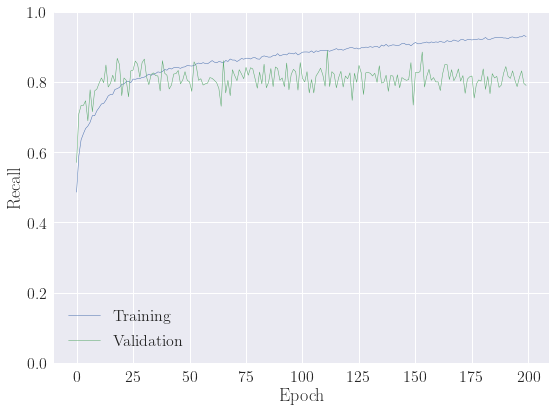

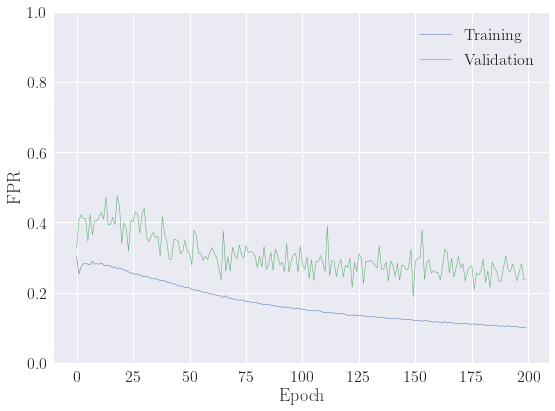

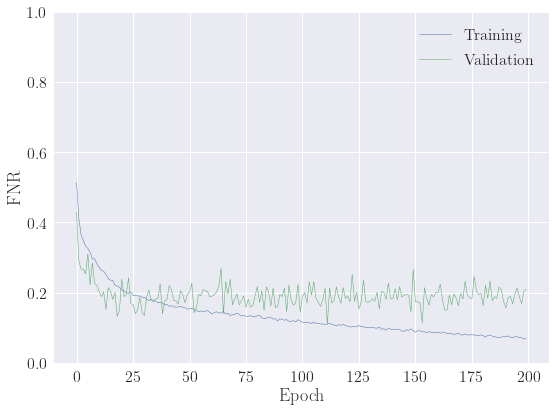

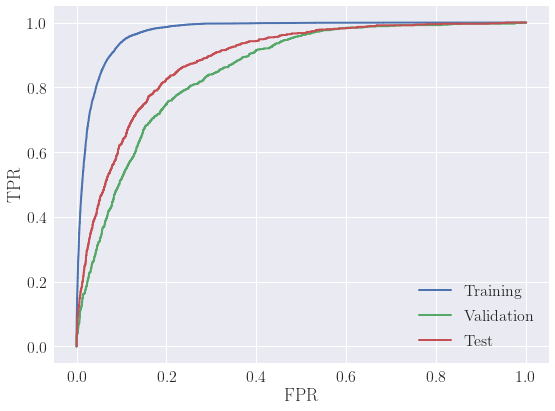

In [9]:
cap.show()

In [10]:
%%capture cap --no-stderr
import pandas as pd


def describe_falses(y, y_pred, dataset_name):
    cm = confusion_matrix(y, y_pred)
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    n = np.sum(np.equal(y, 0))
    p = np.sum(np.equal(y, 1))
    fpr = fp / n
    fnr = fn / p
    
    mcc = matthews_corrcoef(y, y_pred)
    
    return mcc, fpr, fnr


row = ["w_f \\ w_b"] + [str(w_b) for w_b in np.arange(0, 37, 12)]
mccs_train = [row]
mccs_val = [row]
mccs_test = [row]

for w_f in np.arange(0, 37, 12):
    row_train = [str(w_f)]
    row_val = [str(w_f)]
    row_test = [str(w_f)]
    
    for w_b in np.arange(0, 37, 12):
        Y_train_pred_c = correct_predictions(Y_all[train_ids], Y_all_train_pred, w_f=w_f, w_b=w_b)[mask_targets[train_ids]]
        res = describe_falses(Y_train, Y_train_pred_c, "Train")
        row_train.append("{:.3f}/{:.3f}/{:.3f}".format(*res))
        
        Y_val_pred_c = correct_predictions(Y_all[val_ids], Y_all_val_pred, w_f=w_f, w_b=w_b)[mask_targets[val_ids]]
        res = describe_falses(Y_val, Y_val_pred_c, "Val")
        row_val.append("{:.3f}/{:.3f}/{:.3f}".format(*res))
        
        Y_test_pred_c = correct_predictions(Y_all[test_ids], Y_all_test_pred, w_f=w_f, w_b=w_b)[mask_targets[test_ids]]
        res = describe_falses(Y_test, Y_test_pred_c, "Test")
        row_test.append("{:.3f}/{:.3f}/{:.3f}".format(*res))

    mccs_train.append(row_train)
    mccs_val.append(row_val)
    mccs_test.append(row_test)
    
print("train")
print(pd.DataFrame(mccs_train).to_string(index=False))

print("\nval")
print(pd.DataFrame(mccs_val).to_string(index=False))

print("\ntest")
print(pd.DataFrame(mccs_test).to_string(index=False))

In [11]:
cap.show()

with open(os.path.join(model_dir, "log.txt"), "a") as f:
    f.write(cap.stdout)

train
        0                 1                 2                 3                 4
w_f \ w_b                 0                12                24                36
        0 0.666/0.087/0.080 0.686/0.087/0.050 0.693/0.087/0.038 0.698/0.087/0.030
       12 0.667/0.087/0.080 0.686/0.087/0.050 0.693/0.087/0.038 0.698/0.087/0.030
       24 0.736/0.059/0.080 0.755/0.059/0.050 0.762/0.059/0.038 0.768/0.059/0.030
       36 0.780/0.044/0.080 0.799/0.044/0.050 0.806/0.044/0.038 0.811/0.044/0.030

val
        0                 1                 2                 3                 4
w_f \ w_b                 0                12                24                36
        0 0.413/0.238/0.210 0.457/0.238/0.146 0.475/0.238/0.119 0.495/0.238/0.091
       12 0.413/0.238/0.210 0.457/0.238/0.146 0.476/0.238/0.119 0.495/0.238/0.091
       24 0.461/0.195/0.210 0.506/0.195/0.146 0.525/0.195/0.119 0.544/0.195/0.091
       36 0.507/0.160/0.210 0.551/0.160/0.146 0.570/0.160/0.119 0.589/0.160/0.091

test

In [12]:
sample_experience_dir = make_dir(os.path.join(Const.EXPERIENCE_DIR, "data-aug-sample"))
case, collector_sample = load_experience(case_name, agent_name, sample_experience_dir, env_dc=env_dc)

_, _, _, X_all_sample, Y_all_sample, _ = create_dataset(
    case,
    collector_sample,
    input_mode=input_mode,
    label_mode=label_mode,
    n_window_history=n_window_history,
    n_window_targets=n_window_targets,
    downsampling_rate=downsampling_rate,
    n_window_forecasts=n_window_forecasts,
    use_actions=use_actions,
    feature_scaling=feature_scaling,
)


L2RPN_2019_ART (dc)


--------------------------------------------------------------------------------
                                        Loading Experience
--------------------------------------------------------------------------------
    - Loading chronics:                 ./experience/data-aug-sample/l2rpn_2019_art-dc/agent-mip-chronic-****
    - Number of loaded chronics:        10
    - Input structure:                  structured
    - Label structure:                  dn
    - Labels:                           655/60864	1.08 %



    - Dataset                          Chronic 0
        - Loss:                         0.3102
        - TP:                           28/33             84.85 %
        - FP:                           1014/6879         14.74 %
        - TN:                           5865/6879         85.26 %
        - FN:                           5/33              15.15 %
        - Accuracy:                     0.8526
        - Mcc:                          0.1351
        - S %                           0.15075231481481483

    - Dataset                          Chronic 1
        - Loss:                         1.0228
        - TP:                           4/5               80.00 %
        - FP:                           58/195            29.74 %
        - TN:                           137/195           70.26 %
        - FN:                           1/5               20.00 %
        - Accuracy:                     0.7050
        - Mcc:                          0.1697
        - S %                 

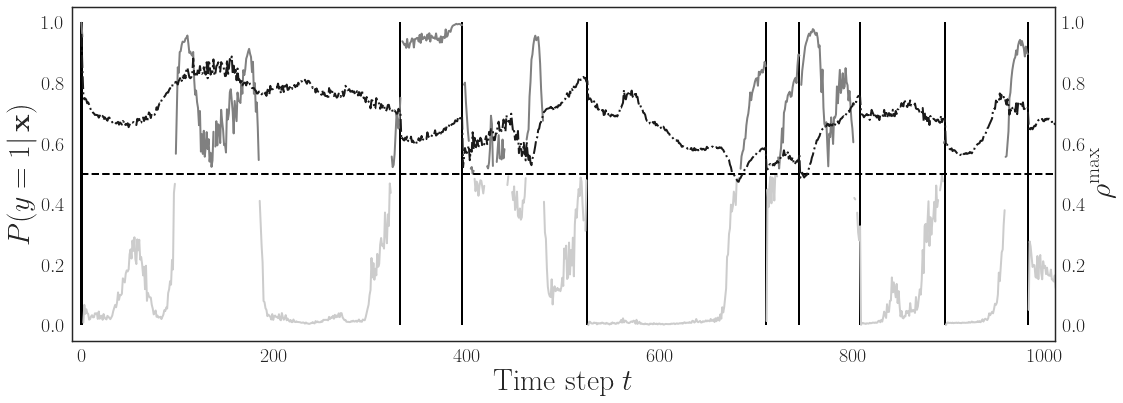

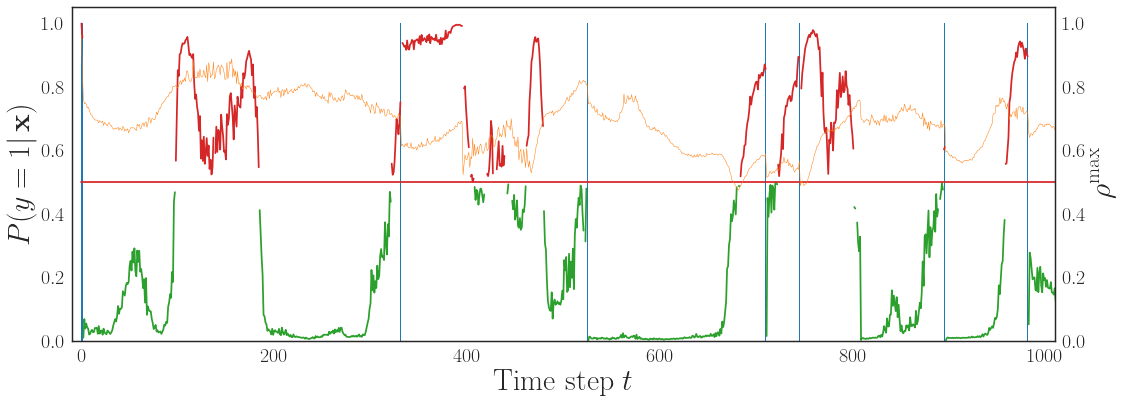

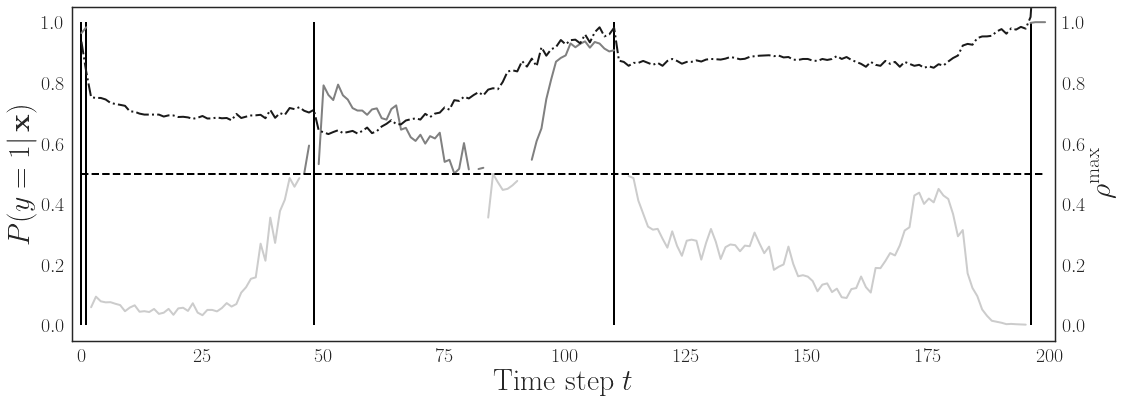

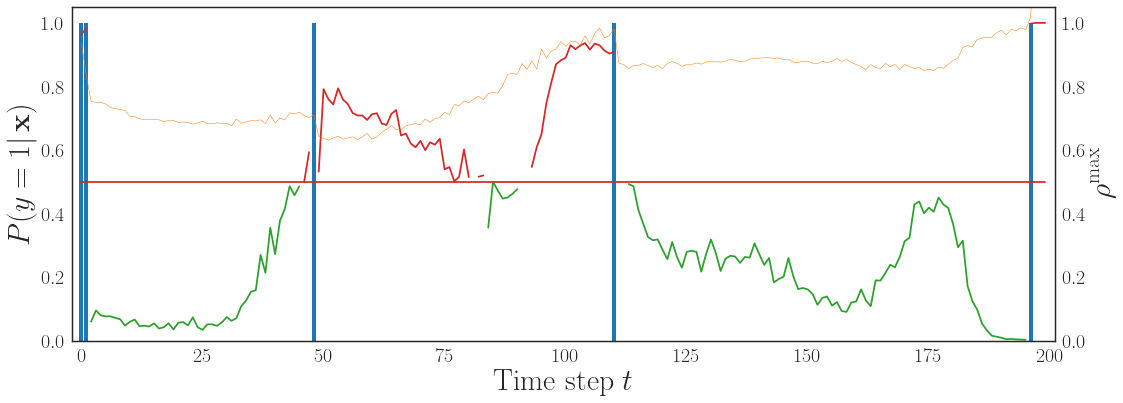

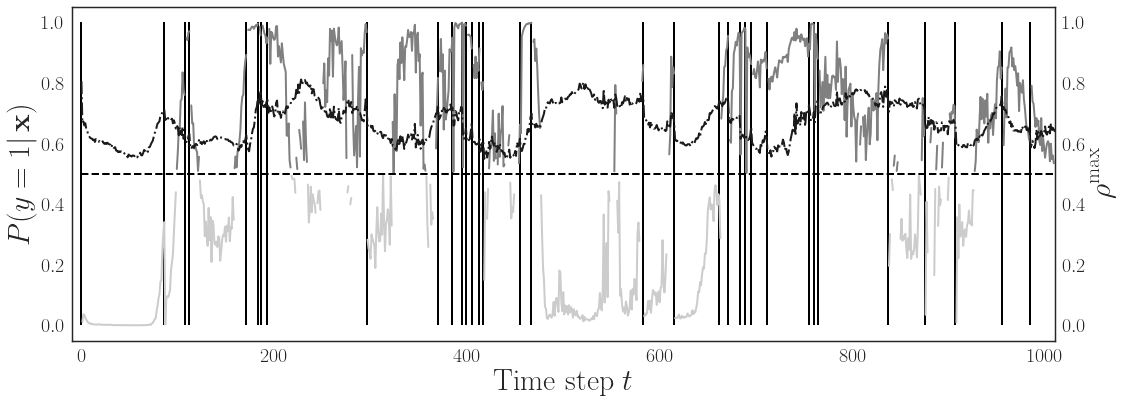

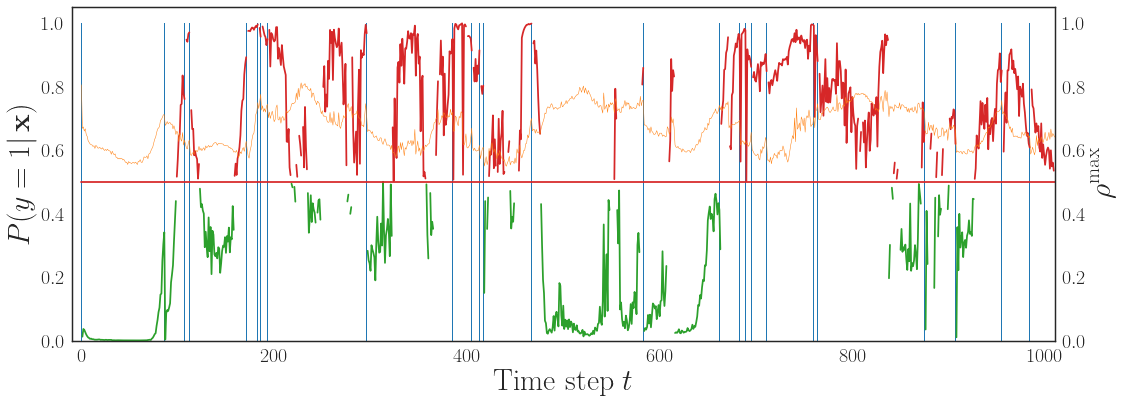

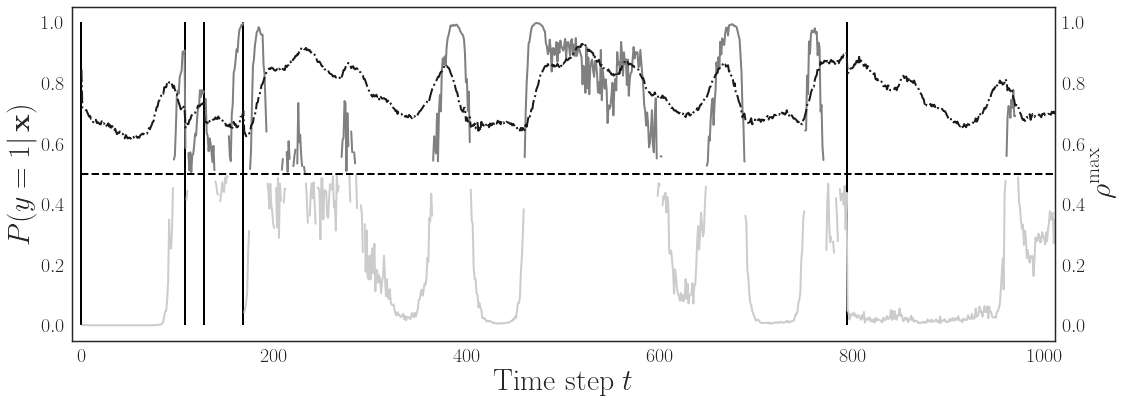

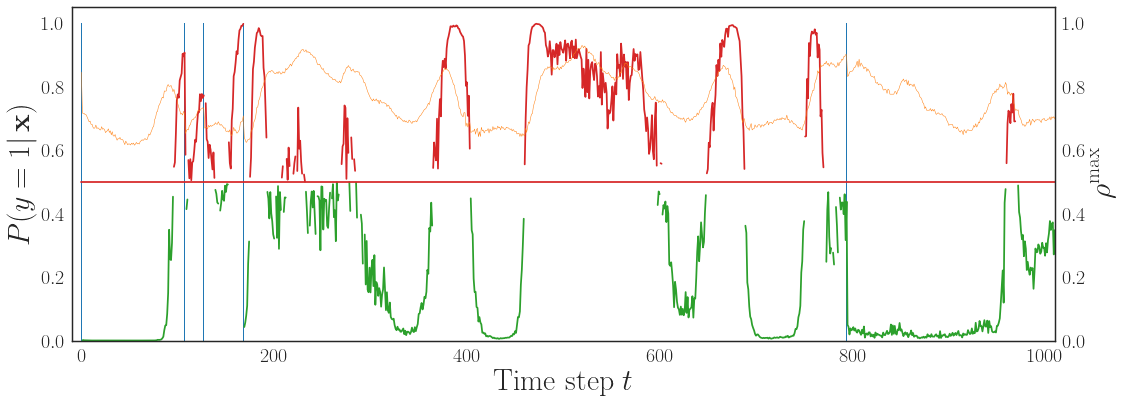

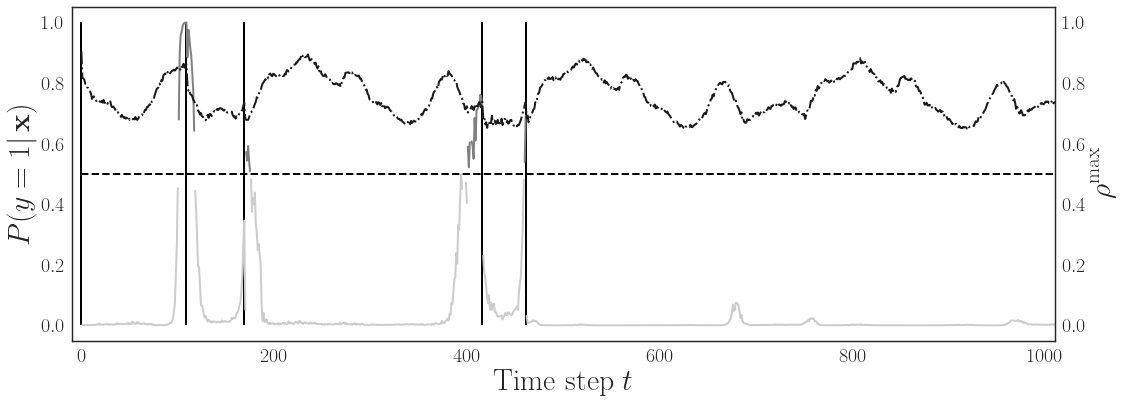

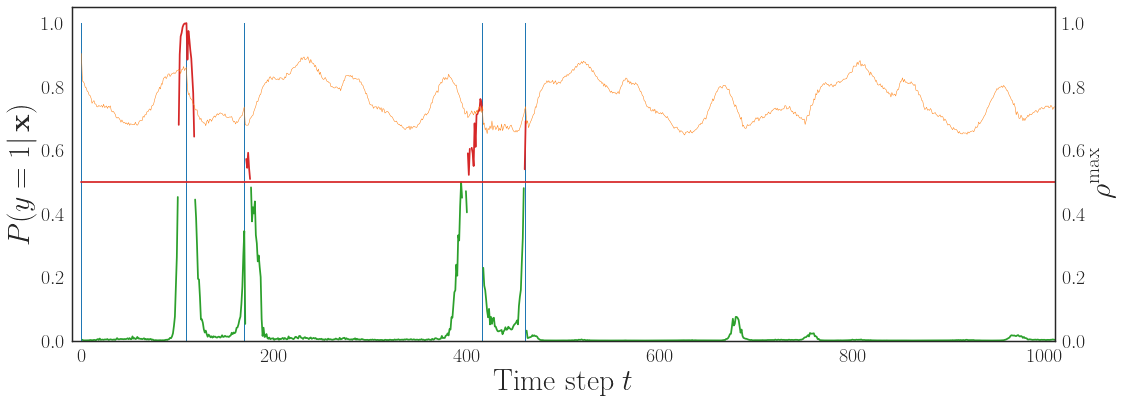

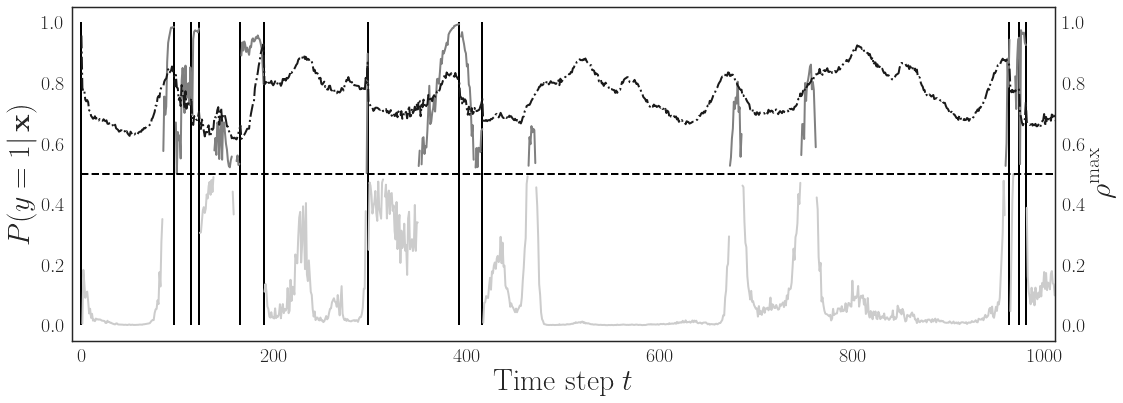

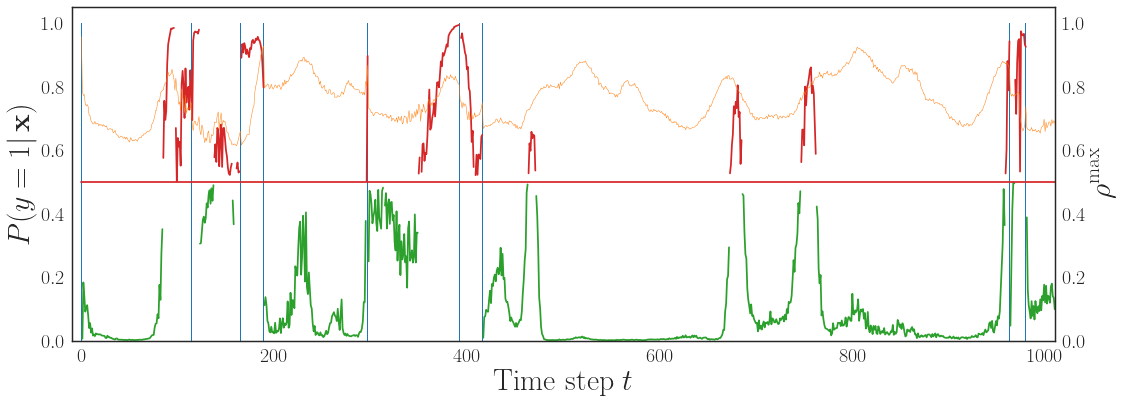

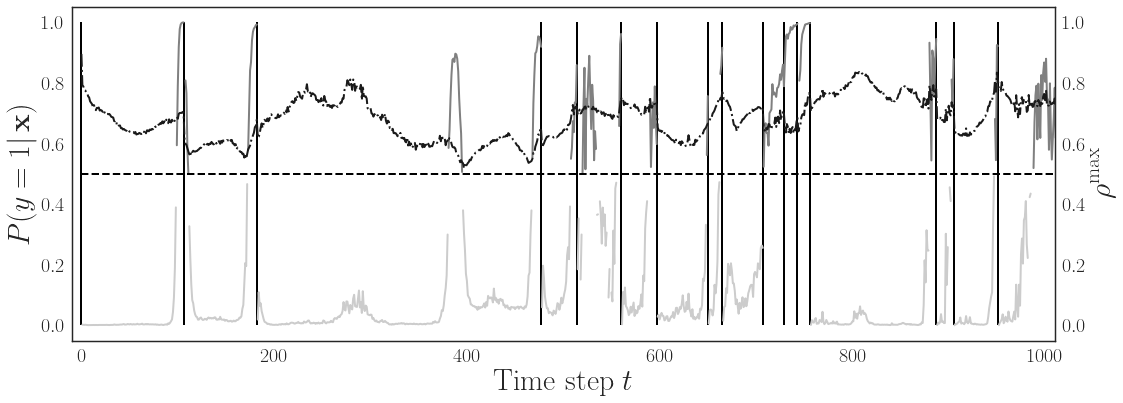

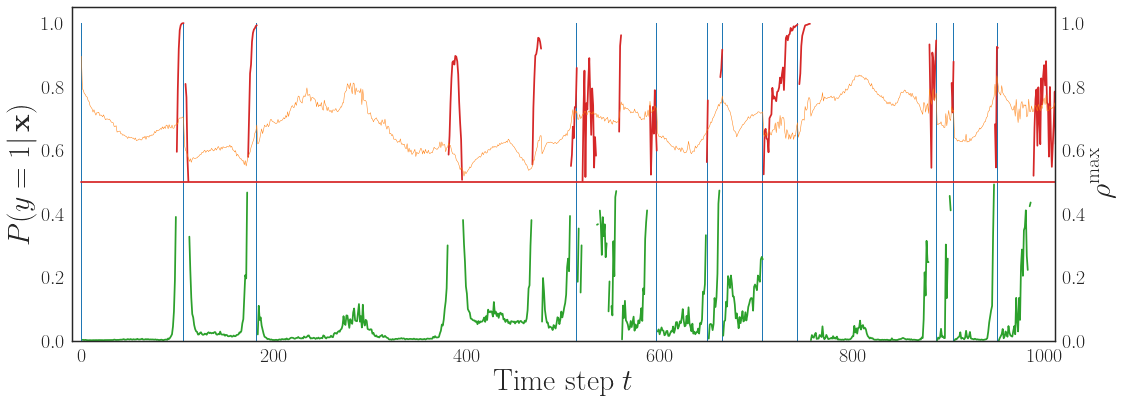

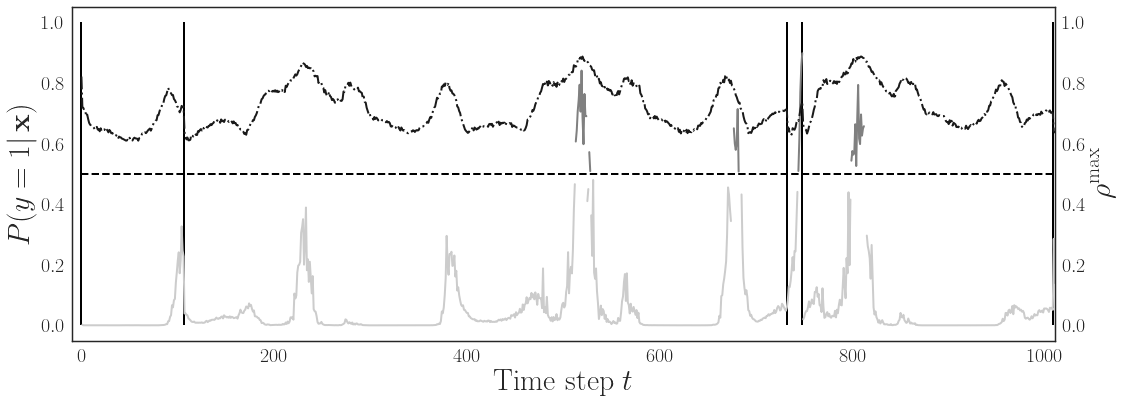

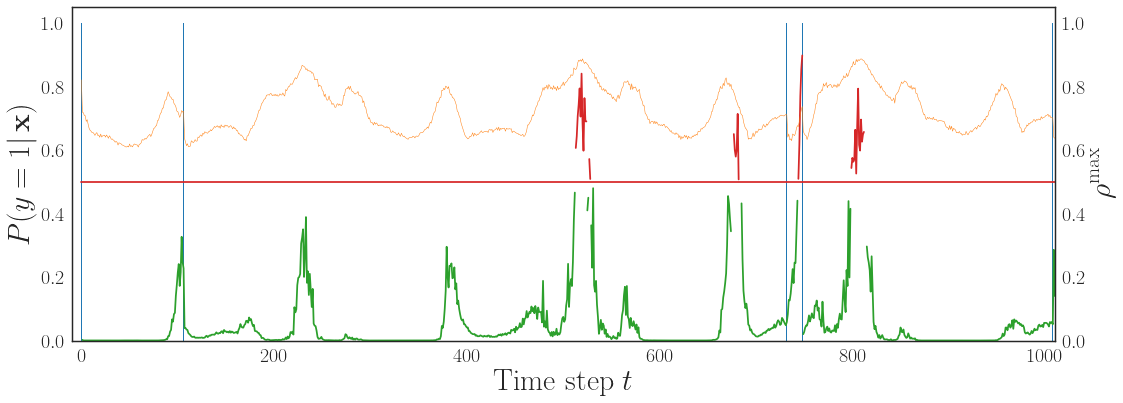

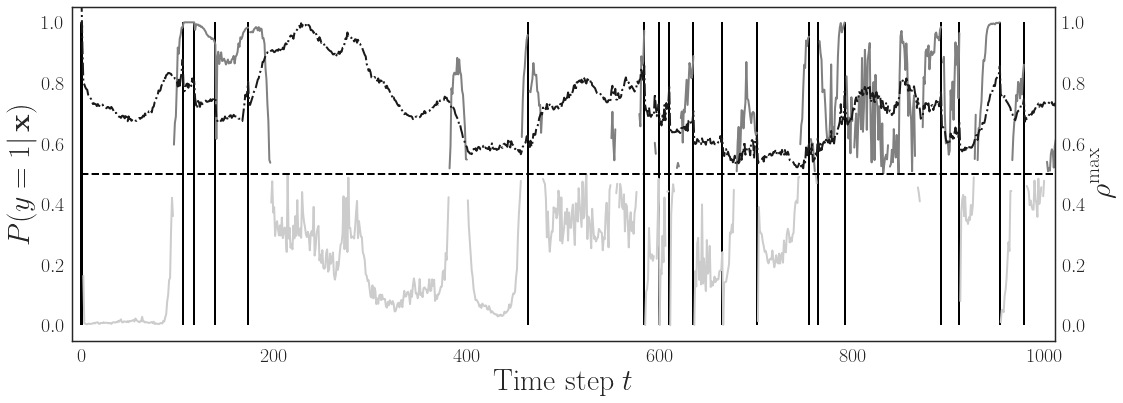

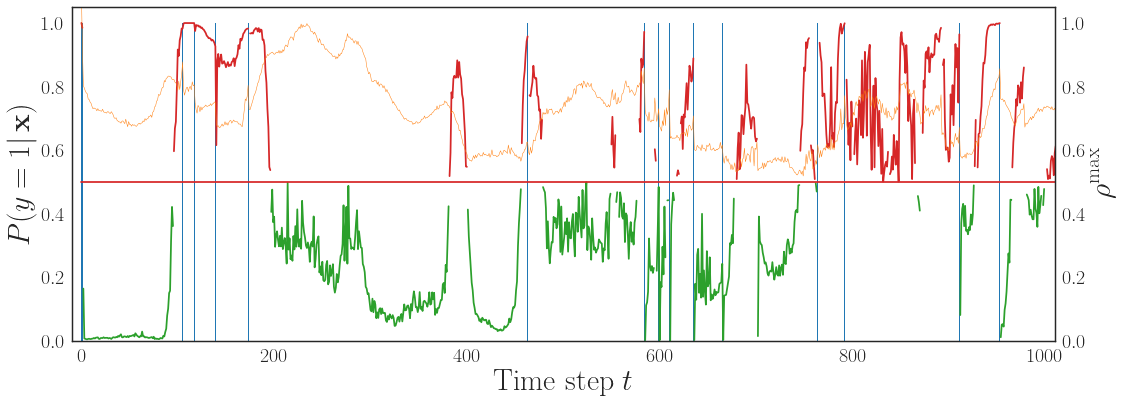

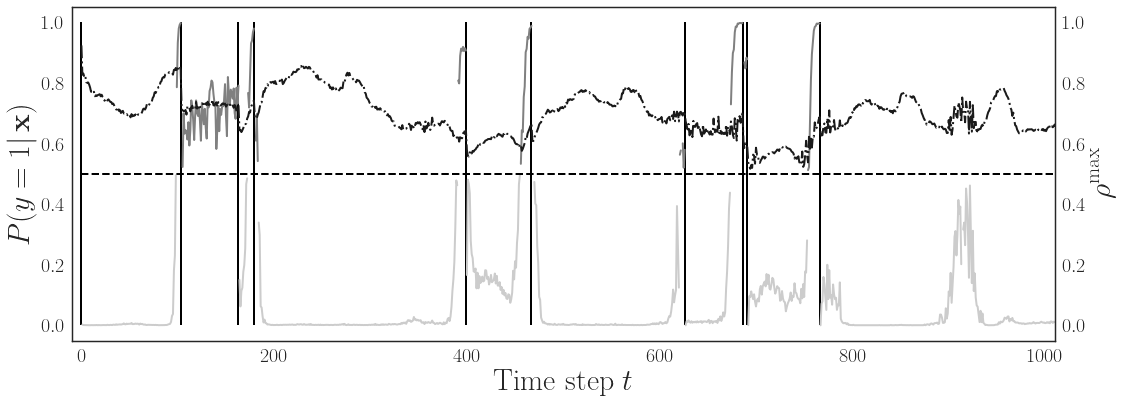

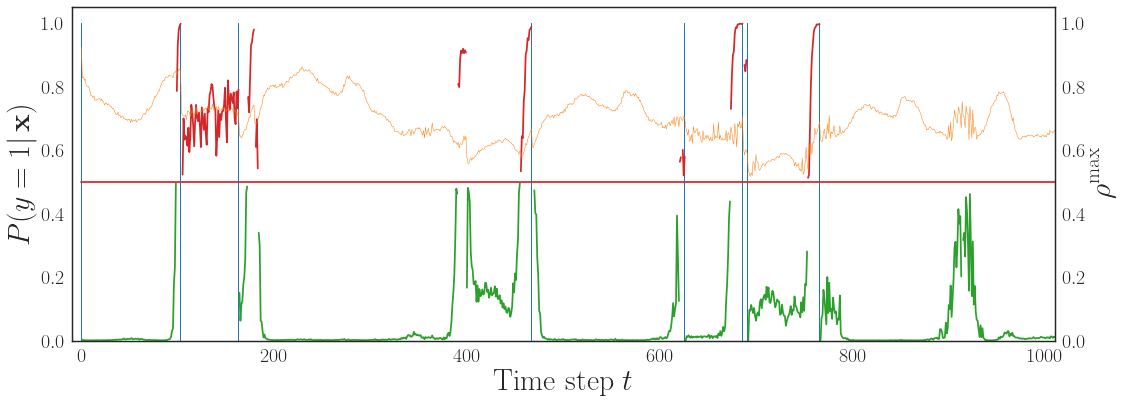

In [14]:
plt.style.use("seaborn-white")
plt.rcParams["font.family"] = "pcr"
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 30


def plot_preds(t, y, y_pred, rhos, threshold, chronic_idx=None):
    fig, ax = plt.subplots(figsize=(Const.FIG_SIZE[0] * 2, Const.FIG_SIZE[1]))

    indices_pos = np.equal(y, 1)
    ax.vlines(t[indices_pos], ymin=0.0, ymax=1.0, colors="0.0", linestyle="-", lw=2.0)
    
    indices_pos = np.greater(y_pred, threshold)
    pos = np.ma.masked_where(np.greater_equal(y_pred, threshold), y_pred)
    neg = np.ma.masked_where(np.less_equal(y_pred, threshold), y_pred)
    
    ax.plot(t, pos, color="0.8", lw=2.0)
    ax.plot(t, neg, color="0.5", lw=2.0)
    ax.plot(t, np.ones_like(t) * threshold, color="0", linestyle="--", lw=2.0)

    ax.set_xlabel(r"Time step $t$")
    ax.set_ylabel(r"$P(y = 1 | \, \mathbf{x})$")

    if ax.get_xlim()[-1] > 1000:
        ax.set_xlim(right=1010, left=-0.01 * 1000)
    else:
        ax.set_xlim(left=-0.01 * t.max(), right=1.01 * t.max())
                
    fig.tight_layout()
    if model_dir and not isinstance(chronic_idx, type(None)):
        fig.savefig(os.path.join(model_dir, "test-y-step-{:04}".format(chronic_idx)))
        
    if not isinstance(rhos, type(None)):
        ax2 = ax.twinx()
        ax2.set_ylabel(r"$\rho^\mathrm{max}$")
        ax2.plot(t, rhos, label=r"$y$", color="0.1", lw=2.0, linestyle="-.")
        ax2.set_ylim(*ax.get_ylim())
        
    fig.tight_layout()
    if model_dir and not isinstance(chronic_idx, type(None)):
        fig.savefig(os.path.join(model_dir, "test-y-step-{:04}-rhos".format(chronic_idx)))

def plot_preds_color(t, y, y_pred, rhos, threshold, chronic_idx=None):
    fig, ax = plt.subplots(figsize=(Const.FIG_SIZE[0] * 2, Const.FIG_SIZE[1]))

    indices_pos = np.equal(y, 1)
    ax.bar(t[indices_pos], y[indices_pos], label=r"$y$", color="tab:blue", lw=1.5)

    indices_pos = np.greater(y_pred, threshold)
    pos = np.ma.masked_where(np.greater_equal(y_pred, threshold), y_pred)
    neg = np.ma.masked_where(np.less_equal(y_pred, threshold), y_pred)
    ax.plot(t, pos, "tab:green", t, neg, "tab:red")

    ax.plot(t, np.ones_like(t) * threshold, label=r"$y$", color="tab:red")

    ax.set_xlabel(r"Time step $t$")
    ax.set_ylabel(r"$P(y = 1 | \, \mathbf{x})$")
    
    if ax.get_xlim()[-1] > 1000:
        ax.set_xlim(right=1010, left=-0.01 * 1000)
    else:
        ax.set_xlim(left=-0.01 * t.max(), right=1.01 * t.max())

    fig.tight_layout()
    if model_dir and not isinstance(chronic_idx, type(None)):
        fig.savefig(os.path.join(model_dir, "test-y-step-{:04}_color".format(chronic_idx)))
        
    if not isinstance(rhos, type(None)):
        ax2 = ax.twinx()
        ax2.set_ylabel(r"$\rho^\mathrm{max}$")
        ax2.plot(t, rhos, label=r"$y$", lw=Const.LW, color="tab:orange")
        ax2.set_ylim(*ax.get_ylim())

    fig.tight_layout()
    if model_dir and not isinstance(chronic_idx, type(None)):
        fig.savefig(os.path.join(model_dir, "test-y-step-{:04}-rhos_color".format(chronic_idx)))
        
        
start_idx = 0
for chronic_idx, chronic_len in zip(collector_sample.chronic_ids, collector_sample.chronic_lengths):
    X_chronic = X_all_sample[start_idx:(start_idx + chronic_len), :]
    Y_chronic = Y_all_sample[start_idx:(start_idx + chronic_len)]

    Y_chronic_pred = model.predict(X_chronic, batch_size=n_batch).flatten()
    
    results_chronic = model.evaluate(X_chronic, Y_chronic, batch_size=n_batch, verbose=0)
    describe_results(model.metrics_names, results_chronic, Y_chronic, name=f"Chronic {chronic_idx}")

    pprint("        - S %", np.mean(Y_chronic_pred > 0.5))
    
    t = np.arange(chronic_len)
    rhos = [np.max(obs.rho) for obs in collector_sample.data[chronic_idx]["obses"][:-1]]
        
    plot_preds(t, Y_chronic, Y_chronic_pred, rhos, threshold, chronic_idx)
    plot_preds_color(t, Y_chronic, Y_chronic_pred, rhos, threshold, chronic_idx)
    
    start_idx = start_idx + chronic_len